In [1]:
#import the necessary libraries 
import helper
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

In [2]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
sign_names = pd.read_csv("signnames.csv", index_col=0)
sign_names= np.array(sign_names)
print(sign_names[33])

['Turn right ahead']


In [4]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


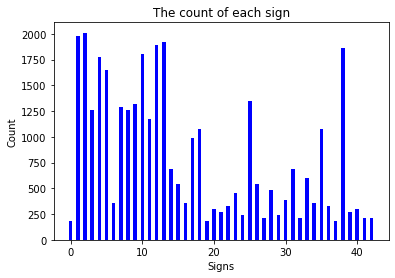

In [5]:
## Graph showing the count of each classes 
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='b')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.savefig("Count of each sign")


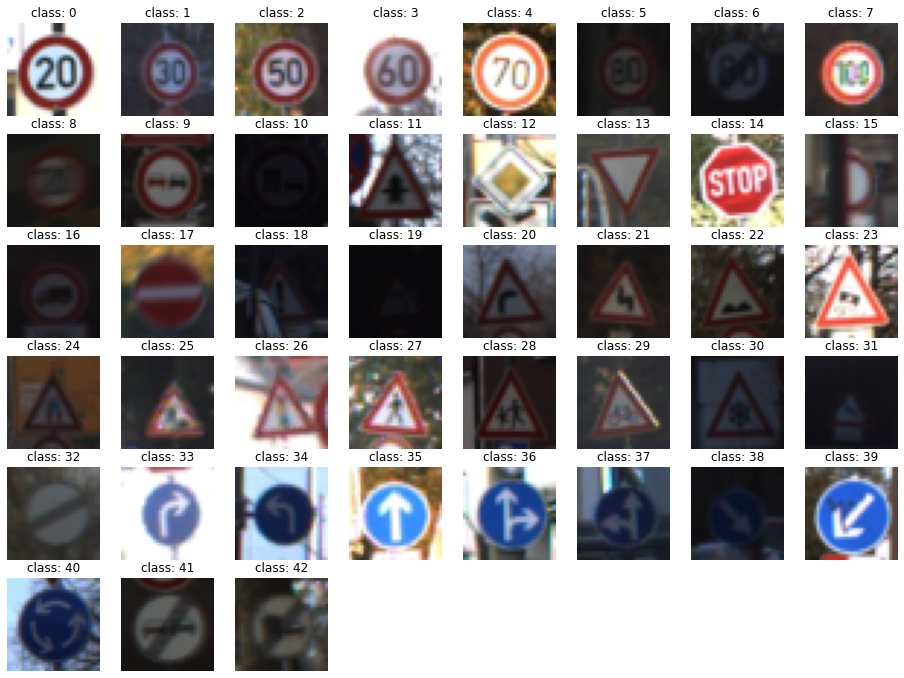

In [6]:
# Images from each class 
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')    
    plt.title('class: {}'.format(c))
    plt.xlabel("class")
    plt.imshow(X_train[i])
plt.savefig("Image of each sign")
    

In [7]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [8]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [9]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
torch.manual_seed(1)

In [11]:
#Convert the dataset to tensor form 
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Train the model on GPU if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [13]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [14]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [15]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [16]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    t_l =[]
    v_l=[]
    for epoch in range(epochs):
        # Train model
        
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        t_l.append(train_loss)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            v_l.append(valid_loss)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
    return v_l,t_l

In [17]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")
    

In [18]:
result = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.675417	Validation loss: 3.591743	 Validation accruacy: 5.578%
[Epoch 2/20] Train loss: 3.484753	Validation loss: 3.570508	 Validation accruacy: 6.553%
[Epoch 3/20] Train loss: 3.457674	Validation loss: 3.540419	 Validation accruacy: 7.052%
[Epoch 4/20] Train loss: 3.341505	Validation loss: 3.352471	 Validation accruacy: 17.075%
[Epoch 5/20] Train loss: 2.718756	Validation loss: 2.373314	 Validation accruacy: 37.234%
[Epoch 6/20] Train loss: 1.724413	Validation loss: 1.639816	 Validation accruacy: 53.197%
[Epoch 7/20] Train loss: 1.149941	Validation loss: 1.171707	 Validation accruacy: 66.735%
[Epoch 8/20] Train loss: 0.859912	Validation loss: 0.970216	 Validation accruacy: 72.630%
[Epoch 9/20] Train loss: 0.681410	Validation loss: 0.952476	 Validation accruacy: 72.608%
[Epoch 10/20] Train loss: 0.564549	Validation loss: 0.813672	 Validation accruacy: 77.596%
[Epoch 11/20] Train loss: 0.477375	Validation loss: 0.735447	 Validation accruacy: 79.615%
[Epoch 12/2

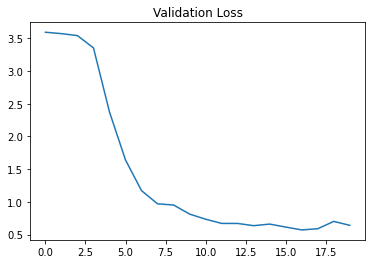

In [19]:
x= [i for i in range(n_epochs)]
y = result[0]
plt.plot(x,y)
plt.title("Validation Loss")
plt.show()
#plt.savefig("Validation Loss")

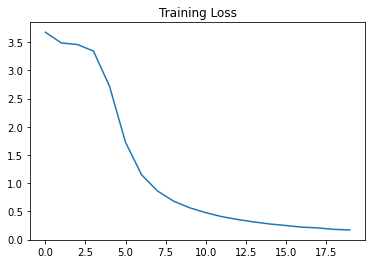

In [20]:
x= [i for i in range(n_epochs)]
y = result[1]
plt.plot(x,y)
plt.title("Training Loss")
plt.show()
#plt.savefig("Training Loss")

In [21]:
test_loader

In [22]:
x, y = next(iter(test_loader))

Text(0.5, 1.0, 'Actaul Label: 4')

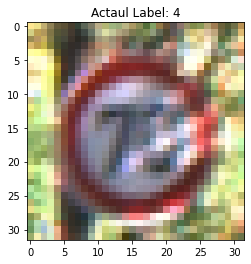

In [23]:
plt.imshow(x[14].numpy().transpose((1, 2, 0)).squeeze(), cmap='Greys_r');
plt.title('Actaul Label: {}'.format(y[14]))

In [24]:
o = model(x)
loss = criterion(o, y)
#loss
pred = torch.argmax(o, dim=1)

#correct
print(pred[0].numpy())


16


In [25]:
correct = pred == y.view(*pred.shape)
correct

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

Actual Sign: ['Pedestrians']
Predicted Sign:['Pedestrians']


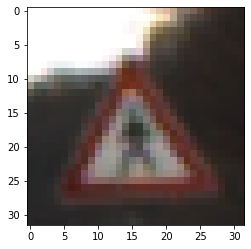

In [26]:
plt.imshow(x[18].numpy().transpose((1, 2, 0)).squeeze(), cmap='Greys_r');
print('Actual Sign: {0}'.format(sign_names[y[18]]))
print('Predicted Sign:{0}'.format(sign_names[pred[18].numpy()]))

Actual Sign: ['Speed limit (30km/h)']
Predicted Sign:['Speed limit (30km/h)']


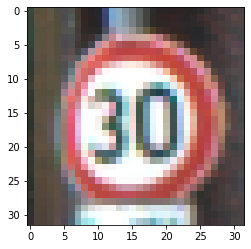

In [27]:
plt.imshow(x[1].numpy().transpose((1, 2, 0)).squeeze(), cmap='Greys_r');
print('Actual Sign: {0}'.format(sign_names[y[1]]))
print('Predicted Sign:{0}'.format(sign_names[pred[1].numpy()]))

In [ ]:
plt.imshow(x[18].numpy().transpose((1, 2, 0)).squeeze(), cmap='Greys_r');
print('Actual Sign: {0}'.format(sign_names[y[18]]))
print('Predicted Sign:{0}'.format(sign_names[pred[18].numpy()]))